In [1]:
import warnings
warnings.filterwarnings("ignore")

In [124]:
pd.set_option("display.max_columns", None)

In [ ]:
!pip install xgboost # install the library

# import the necessary machine learning libraries

In [176]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# import the label Encoder library 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [195]:
market_df = pd.read_csv("bank.csv") # load the csv file

In [178]:
market_df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


In [ ]:
market_df.describe(include = "all").T #getting the general statistical breakdown of the dataset 

In [ ]:
market_df.isnull().sum() # check for missing values 

In [ ]:
market_df.info() #check the general info on the number of rows and columns and the datatypes of each column

# Prepare the data by cleaning and replacing necessary entries 

In [196]:
# Change the names of some parts of the data in the job, contact and education columns in the dataframe

market_df["job"] = market_df["job"].replace({"admin.": "admin"})

market_df["contact"] = market_df["contact"].replace({"unknown": "Not Known"})

market_df["education"] = market_df["education"].replace({"unknown": "unavailable"})

market_df["job"] = market_df["job"].replace({"unknown": "missing"})

In [197]:
# Perform the label Encoding for the default, housing, loan columns in the dataframe
market_df["default"] = label_encoder.fit_transform(market_df["default"])
market_df["housing"] = label_encoder.fit_transform(market_df["housing"])
market_df["loan"] = label_encoder.fit_transform(market_df["loan"])
market_df["deposit"] = label_encoder.fit_transform(market_df["deposit"])

# Display some visualizations for the dataset

# For the categorical Data

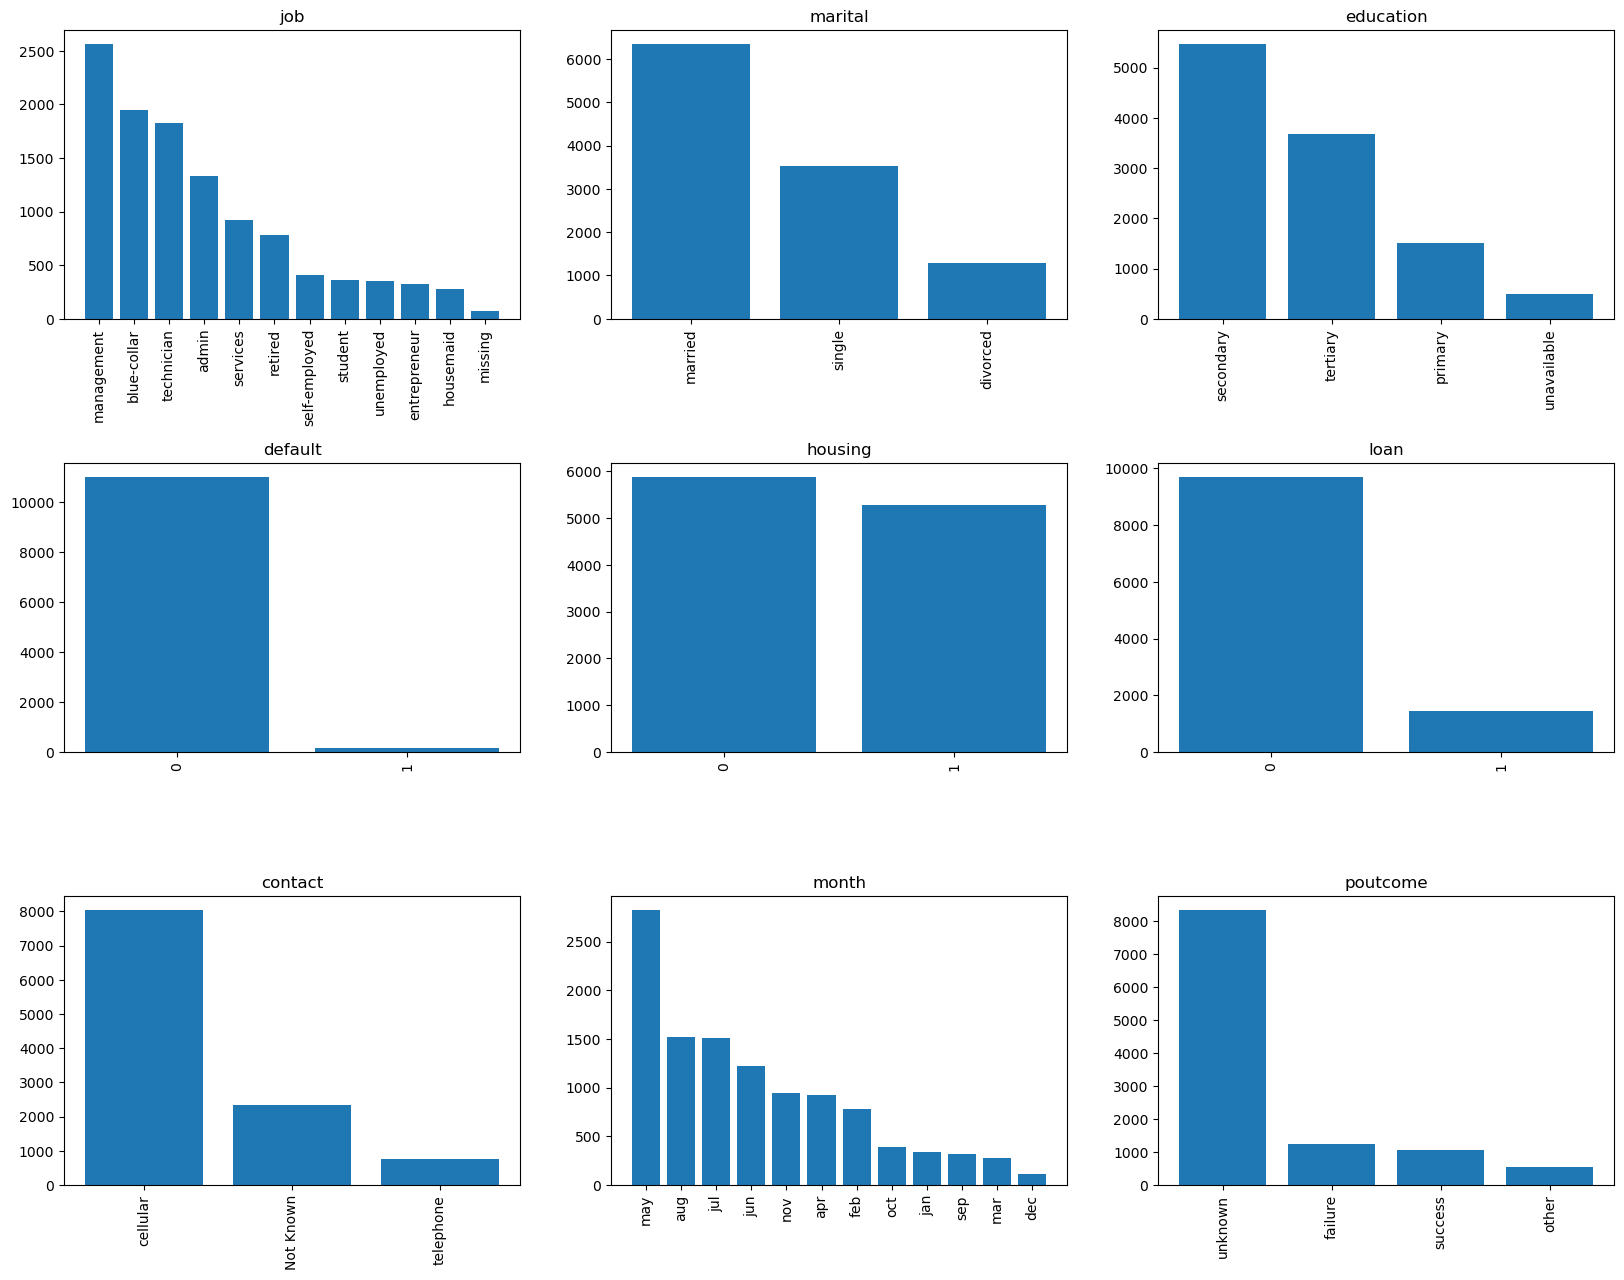

In [198]:
# Define categorical columns to be plotted
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Create a 3x3 grid of subplots with shared x and y axes turned off, and set the figure size
fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

# Initialize a counter to track the subplot positions
counter = 0

# Loop through each categorical column to create bar plots
for cat_column in cat_columns:
    # Get the value counts (frequency) of the current categorical column
    value_counts = market_df[cat_column].value_counts()
    
    # Determine the row index of the subplot (trace_x)
    trace_x = counter // 3
    
    # Determine the column index of the subplot (trace_y)
    trace_y = counter % 3
    
    # Create an array of positions for the bars on the x-axis
    x_pos = np.arange(0, len(value_counts))
    
    # Create a bar plot in the appropriate subplot with tick labels from the value counts
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label=value_counts.index)

    # Set the title of the current subplot to the categorical column name
    axs[trace_x, trace_y].set_title(cat_column)
        
    # Rotate the x-axis tick labels by 90 degrees for better readability
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    # Increment the counter to move to the next subplot position
    counter += 1

# Adjust the spacing between subplots to prevent overlap
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()

In [199]:
# Convert the 'marital' column into dummy variables and join them to the original DataFrame
market_df = market_df.join(pd.get_dummies(market_df.marital))
# Drop the original 'marital' column since it's now represented by the dummy variables
market_df = market_df.drop("marital", axis=1)

# Convert the 'job' column into dummy variables and join them to the original DataFrame
market_df = market_df.join(pd.get_dummies(market_df.job))
# Drop the original 'job' column since it's now represented by the dummy variables
market_df = market_df.drop("job", axis=1)

# Convert the 'education' column into dummy variables and join them to the original DataFrame
market_df = market_df.join(pd.get_dummies(market_df.education))
# Drop the original 'education' column since it's now represented by the dummy variables
market_df = market_df.drop("education", axis=1)

# Convert the 'contact' column into dummy variables and join them to the original DataFrame
market_df = market_df.join(pd.get_dummies(market_df.contact))
# Drop the original 'contact' column since it's now represented by the dummy variables
market_df = market_df.drop("contact", axis=1)

# Convert the 'poutcome' column into dummy variables and join them to the original DataFrame
market_df = market_df.join(pd.get_dummies(market_df.poutcome))
# Drop the original 'poutcome' column since it's now represented by the dummy variables
market_df = market_df.drop("poutcome", axis=1)

# Convert the 'month' column into dummy variables and join them to the original DataFrame
market_df = market_df.join(pd.get_dummies(market_df.month))
# Drop the original 'month' column since it's now represented by the dummy variables
market_df = market_df.drop("month", axis=1)


# For the numerical Data

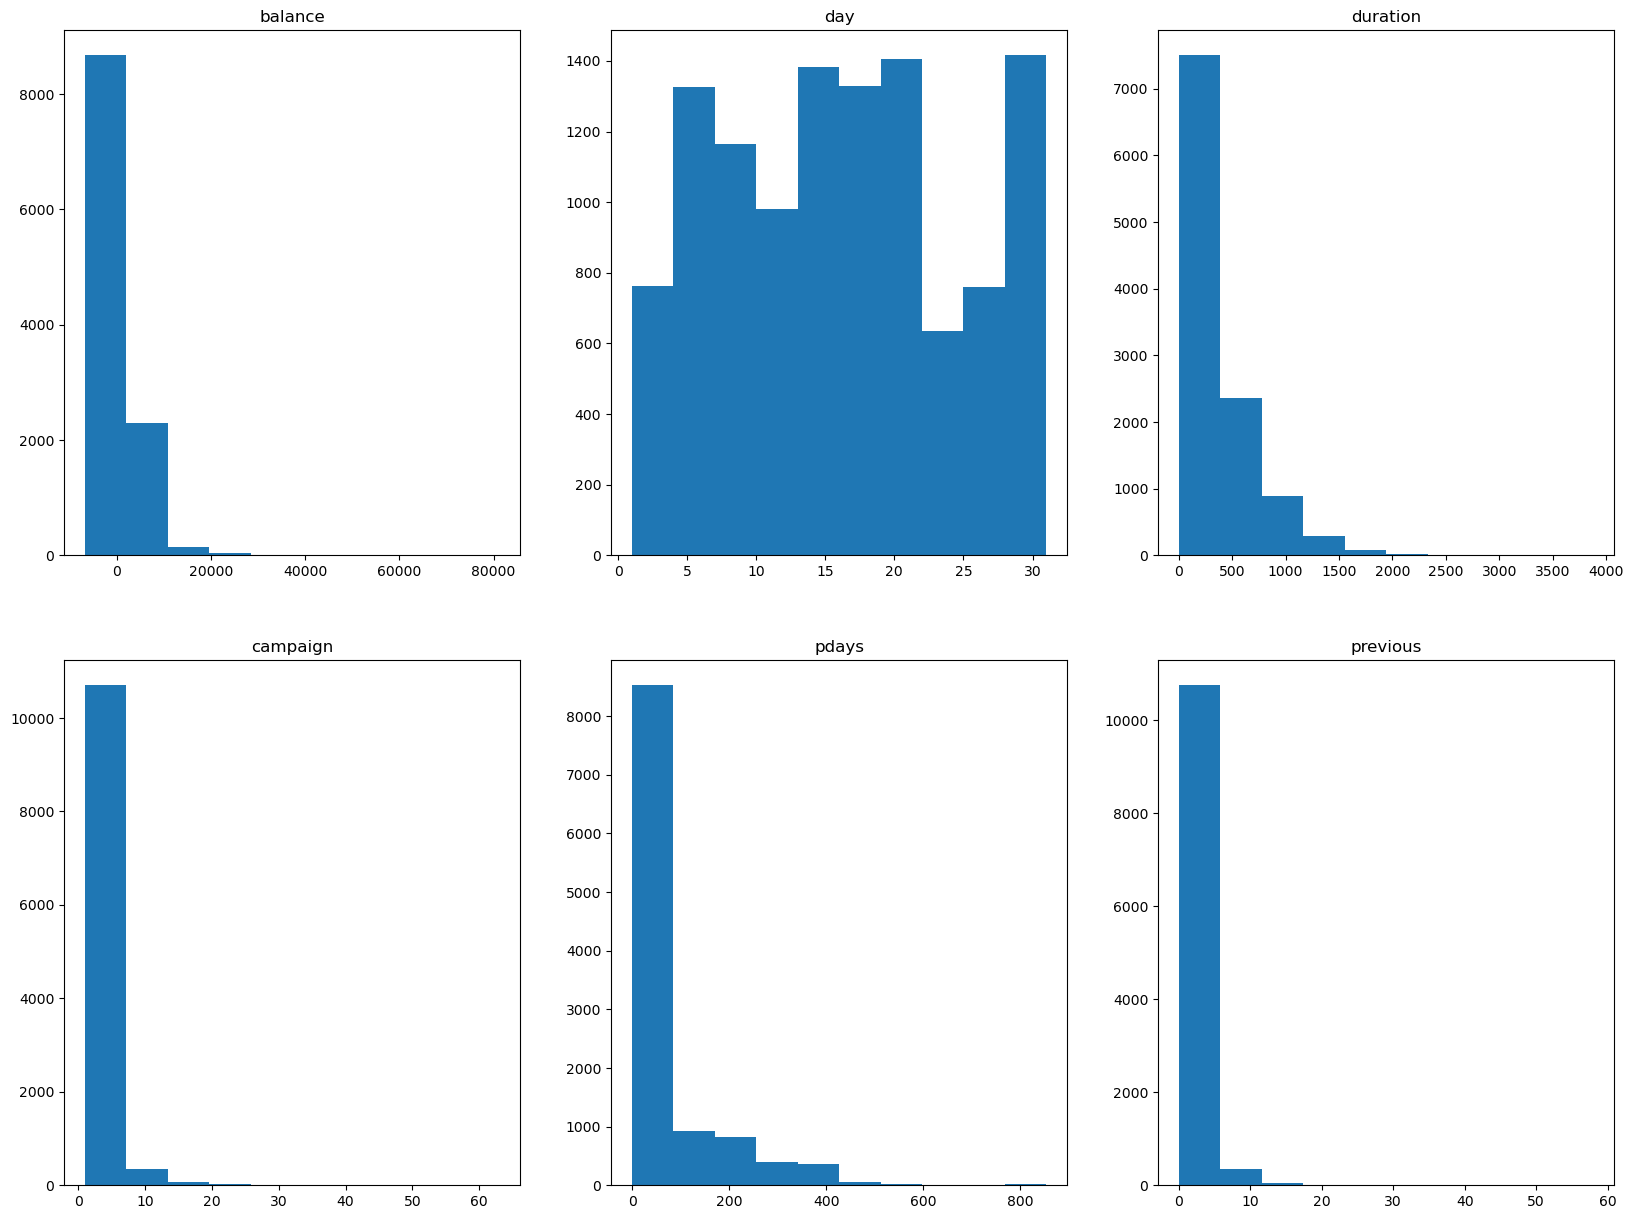

In [200]:
# Define numerical columns to be plotted
num_columns = ['balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Create a 2x3 grid of subplots with independent x and y axes, and set the figure size
fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))

# Initialize a counter to track the subplot positions
counter = 0

# Loop through each numerical column to create histograms
for num_column in num_columns:
    
    # Determine the row index of the subplot (trace_x)
    trace_x = counter // 3
    
    # Determine the column index of the subplot (trace_y)
    trace_y = counter % 3
    
    # Plot a histogram for the current numerical column in the appropriate subplot
    axs[trace_x, trace_y].hist(market_df[num_column])
    
    # Set the title of the current subplot to the numerical column name
    axs[trace_x, trace_y].set_title(num_column)
    
    # Increment the counter to move to the next subplot position
    counter += 1

# Display the plot
plt.show()


In [145]:
market_df

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,deposit,divorced,married,single,admin,blue-collar,entrepreneur,housemaid,management,missing,retired,self-employed,services,student,technician,unemployed,primary,secondary,tertiary,unavailable,Not Known,cellular,telephone,failure,other,success,unknown,apr,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,59,0,2343,1,0,5,1042,1,-1,0,1,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
1,56,0,45,0,0,5,1467,1,-1,0,1,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
2,41,0,1270,1,0,5,1389,1,-1,0,1,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
3,55,0,2476,1,0,5,579,1,-1,0,1,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
4,54,0,184,0,0,5,673,2,-1,0,1,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,0,1,1,0,20,257,1,-1,0,0,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False
11158,39,0,733,0,0,16,83,4,-1,0,0,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
11159,32,0,29,0,0,19,156,2,-1,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False
11160,43,0,0,0,1,8,9,2,172,5,0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [201]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X, y = market_df.drop("deposit", axis=1), market_df["deposit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [202]:
import xgboost

xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for the features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.906: test: 0.859


In [203]:
from sklearn.svm import SVC

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize the SVC model
svc_reg = SVC(kernel='rbf')

# Fit the model to the training data
svc_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_svc = svc_reg.predict(X_test_scaled)

# Calculate accuracy
accuracy_svc = accuracy_score(y_test, y_pred_svc)

# Calculate confusion matrix
conf_matrix_svc = confusion_matrix(y_test, y_pred_svc)

# Calculate classification report
class_report_svc = classification_report(y_test, y_pred_svc)

# Print the metrics
print(f"Support Vector Classification:")
print(f"Accuracy: {accuracy_svc:.4f}")
print("Confusion Matrix:")
print(conf_matrix_svc)
print("Classification Report:")
print(class_report_svc)

Support Vector Classification:
Accuracy: 0.8525
Confusion Matrix:
[[722 133]
 [114 706]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       855
           1       0.84      0.86      0.85       820

    accuracy                           0.85      1675
   macro avg       0.85      0.85      0.85      1675
weighted avg       0.85      0.85      0.85      1675



In [205]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize the GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()

# Fit the model to the training data
gb_clf.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_gb = gb_clf.predict(X_test_scaled)

# Calculate accuracy
accuracy_gb = accuracy_score(y_test, y_pred_gb)

# Calculate confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Calculate classification report
class_report_gb = classification_report(y_test, y_pred_gb)

# Print the metrics
print(f"Gradient Boosting Classifier:")
print(f"Accuracy: {accuracy_gb:.4f}")
print("Confusion Matrix:")
print(conf_matrix_gb)
print("Classification Report:")
print(class_report_gb)

Gradient Boosting Classifier:
Accuracy: 0.8454
Confusion Matrix:
[[714 141]
 [118 702]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       855
           1       0.83      0.86      0.84       820

    accuracy                           0.85      1675
   macro avg       0.85      0.85      0.85      1675
weighted avg       0.85      0.85      0.85      1675



In [206]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize the KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn_clf.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_knn = knn_clf.predict(X_test_scaled)

# Calculate accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)

# Calculate confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Calculate classification report
class_report_knn = classification_report(y_test, y_pred_knn)

# Print the metrics
print(f"K-Nearest Neighbors Classifier:")
print(f"Accuracy: {accuracy_knn:.4f}")
print("Confusion Matrix:")
print(conf_matrix_knn)
print("Classification Report:")
print(class_report_knn)

K-Nearest Neighbors Classifier:
Accuracy: 0.7481
Confusion Matrix:
[[709 146]
 [276 544]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.83      0.77       855
           1       0.79      0.66      0.72       820

    accuracy                           0.75      1675
   macro avg       0.75      0.75      0.75      1675
weighted avg       0.75      0.75      0.75      1675



In [207]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestClassifier
forest_clf = RandomForestClassifier()

# Fit the model to the training data
forest_clf.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_forest = forest_clf.predict(X_test_scaled)

# Calculate accuracy
accuracy_forest = accuracy_score(y_test, y_pred_forest)

# Calculate confusion matrix
conf_matrix_forest = confusion_matrix(y_test, y_pred_forest)

# Calculate classification report
class_report_forest = classification_report(y_test, y_pred_forest)

# Print the metrics
print(f"Random Forest Classifier:")
print(f"Accuracy: {accuracy_forest:.4f}")
print("Confusion Matrix:")
print(conf_matrix_forest)
print("Classification Report:")
print(class_report_forest)

Random Forest Classifier:
Accuracy: 0.8585
Confusion Matrix:
[[730 125]
 [112 708]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       855
           1       0.85      0.86      0.86       820

    accuracy                           0.86      1675
   macro avg       0.86      0.86      0.86      1675
weighted avg       0.86      0.86      0.86      1675



In [209]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Initialize the DecisionTreeClassifier
tree_clf = DecisionTreeClassifier()

# Fit the model to the training data
tree_clf.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_tree = tree_clf.predict(X_test_scaled)

# Calculate accuracy
accuracy_tree = accuracy_score(y_test, y_pred_tree)

# Calculate confusion matrix
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)

# Calculate classification report
class_report_tree = classification_report(y_test, y_pred_tree)

# Print the metrics
print(f"Decision Tree Classifier:")
print(f"Accuracy: {accuracy_tree:.4f}")
print("Confusion Matrix:")
print(conf_matrix_tree)
print("Classification Report:")
print(class_report_tree)

Decision Tree Classifier:
Accuracy: 0.7833
Confusion Matrix:
[[687 168]
 [195 625]]
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       855
           1       0.79      0.76      0.77       820

    accuracy                           0.78      1675
   macro avg       0.78      0.78      0.78      1675
weighted avg       0.78      0.78      0.78      1675



In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred_log = log_reg.predict(X_test_scaled)

# Predict on the training data (for train evaluation)
y_train_pred_log = log_reg.predict(X_train_scaled)

# Evaluate the model on training data
accuracy_train = accuracy_score(y_train, y_train_pred_log)
print(f"Training Data:\n Accuracy: {accuracy_train:.4f}")

# Evaluate the model on test data
accuracy_test = accuracy_score(y_test, y_pred_log)
print(f"Test Data:\n Accuracy: {accuracy_test:.4f}")


Training Data:
 Accuracy: 0.8270
Test Data:
 Accuracy: 0.8227
